In [1]:
# Import basic packages lik numpy, pandas, math plot and seaborn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas_profiling as pr
from sklearn.preprocessing import LabelEncoder

from datetime import datetime
import lightgbm as lgbm
import warnings
from contextlib import contextmanager

@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

warnings.filterwarnings('ignore') #ignore warning messages 

from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, confusion_matrix,  roc_curve, precision_recall_curve, accuracy_score, roc_auc_score


In [2]:
# import dataset
df = pd.read_csv('https://raw.githubusercontent.com/lijjumathew/MSDS-Machine-Learning-1-Project/master/dataset/Telco-Customer-Churn.csv')
df.sample(5).T

,6618,3769,217,6968,6245
customerID,8404-FYDIB,2129-ALKBS,0230-WEQUW,8685-WHQPW,4759-PXTAN
gender,Male,Female,Male,Female,Female
SeniorCitizen,0,0,0,1,0
Partner,No,Yes,Yes,No,Yes
Dependents,No,Yes,No,No,No
tenure,26,40,66,22,59
PhoneService,Yes,Yes,No,Yes,Yes
MultipleLines,Yes,Yes,No phone service,Yes,Yes
InternetService,Fiber optic,No,DSL,Fiber optic,DSL
OnlineSecurity,Yes,No internet service,Yes,No,No


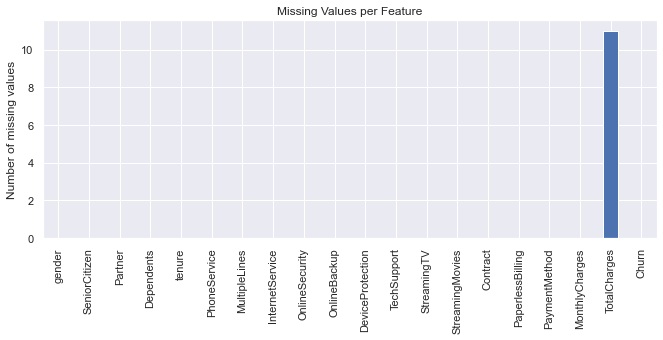

In [3]:
#Separating churn and non churn customers 
churn     = df[df["Churn"] == "Yes"]
not_churn = df[df["Churn"] == "No"]

Id     = ['customerID']
target = ["Churn"]

#Ideally SeniorCitizen column should be a factor, so let's convert 1,0 values to Yes,No and later we can label encode all factor columns
df.SeniorCitizen=df.SeniorCitizen.apply(lambda x: 'Yes' if x==1 else 'No')

# Getting rid of unwanted columns like Customer Id.
if 'customerID' in df:
    del df['customerID']
    
# converting TotalCharges object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors = 'coerce')

# Replacing blank values with nulls.
df=df.replace(r'^\s*$', np.nan, regex=True)
# Total charges has some blank values/missing values and needs to be imputed. Filling the missing values

#the amount of missing values per feature
sns.set(rc={'figure.figsize':(11,4)})
pd.isnull(df).sum().plot(kind='bar')
plt.ylabel('Number of missing values')
plt.title('Missing Values per Feature');

df["TotalCharges"].fillna(df["TotalCharges"].mean(), inplace=True)

In [4]:
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


Text(0.5, 1.0, 'Churn Percentage')

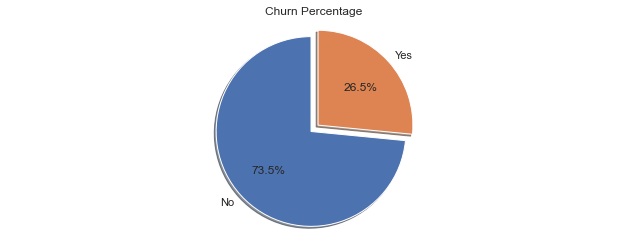

In [5]:
plt.pie(df["Churn"].value_counts(),explode=(0,0.1), autopct='%1.1f%%',shadow=True, startangle=90,labels=df["Churn"].unique())
plt.axis('equal') ;
plt.title('Churn Percentage')

In [6]:
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2265.000258
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,402.225000
50%,29.000000,70.350000,1400.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


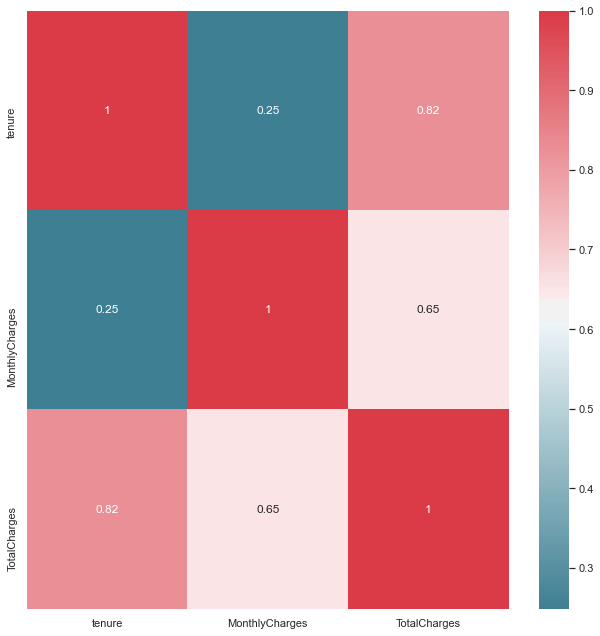

In [7]:
# plot the correlation matrix using seaborn
sns.set(style="darkgrid") # one of the many styles to plot using
cmap = sns.diverging_palette(220, 10, as_cmap=True) # one of the many color mappings

f, ax = plt.subplots(figsize=(9, 9))

sns.heatmap(df.corr(), cmap=cmap, annot=True)
f.tight_layout()
#Tenure and TotalCharges, Monthly and TotalCharges are corelated and it makes sense,as totalcharges = tenure*MonthlyCharges

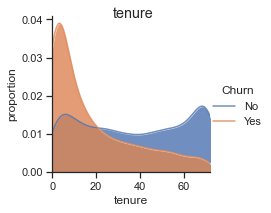

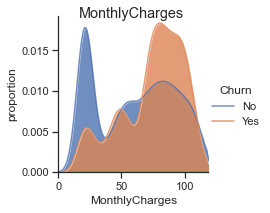

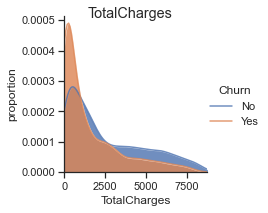

In [8]:
def plot_distribution_num(df_num):
    sns.set_style('ticks')
    s = sns.FacetGrid(df,hue='Churn')
    s.map(sns.kdeplot,df_num,shade = True, alpha = 0.8)
    s.set(xlim=(0,df[df_num].max()))
    s.add_legend()
    s.set_axis_labels(df_num,'proportion')
    s.fig.suptitle(df_num)
    plt.show()
    
plot_distribution_num('tenure')
plot_distribution_num('MonthlyCharges')
plot_distribution_num('TotalCharges')  

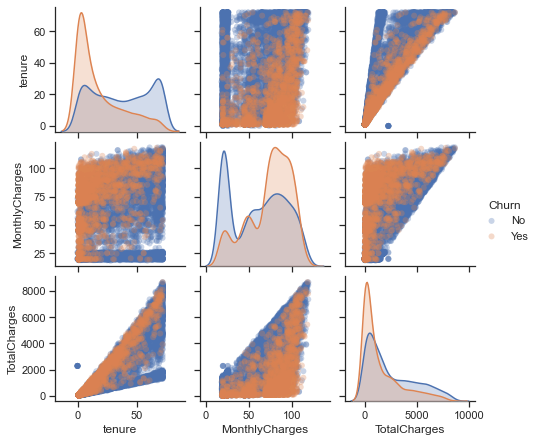

In [9]:
sns.pairplot(df[['tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']], 
             hue='Churn', plot_kws=dict(alpha=.3, edgecolor='none'), height=2, aspect=1.1)

In [10]:
# Tenure in months as year range
df['tenure_range'] = pd.cut(df.tenure,[0,12,24,36,48,60,72,84],3,
                            labels=['1 year','2 year','3 year', ' 4 year', '5 year', '6 year', '7 year'])

# change MonthlyCharges to categorical column 
def monthlycharges_split(df) : 
 if df['MonthlyCharges'] <= 30 :
     return '0–30'
 elif (df['MonthlyCharges'] > 30) & (df['MonthlyCharges'] <= 70 ):
     return '30–70'
 elif (df['MonthlyCharges'] > 70) & (df['MonthlyCharges'] <= 99 ):
     return '70–99'
 elif df['MonthlyCharges'] > 99 :
     return '99plus'
df['monthlycharges_bin'] = df.apply(lambda df:monthlycharges_split(df), axis = 1)

Text(0.5, 1.0, 'Churn by Tenure')

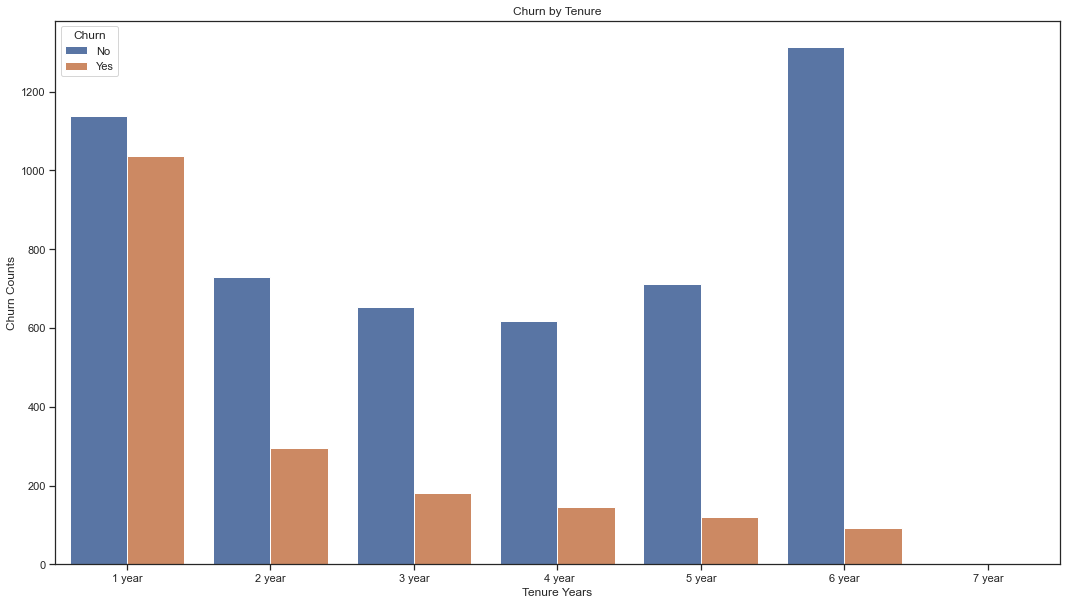

In [11]:
f, axes = plt.subplots(figsize=(18, 10))
sns.countplot(df["tenure_range"],hue = df["Churn"]);
plt.xlabel('Tenure Years')
plt.ylabel('Churn Counts')
plt.title('Churn by Tenure')

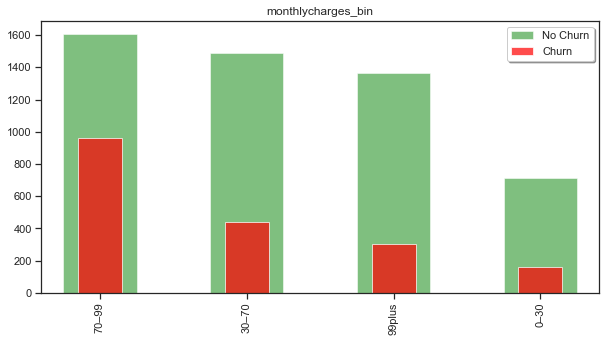

In [12]:
# new features monthlycharges_bin
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['monthlycharges_bin'].value_counts().plot(kind = 'bar', color="green", alpha=0.5).set_title('monthlycharges_bin')
df[df.Churn == "Yes"]['monthlycharges_bin'].value_counts().plot(kind = 'bar', color="red", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

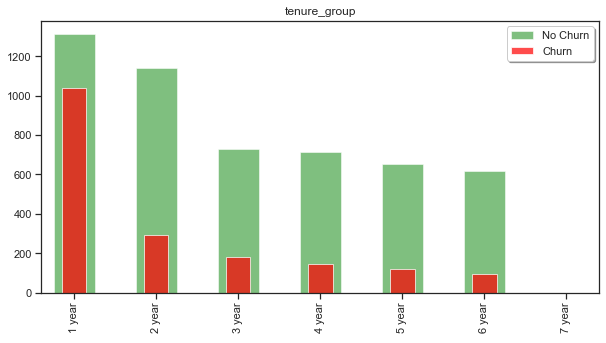

In [13]:
# new features tenure_group
plt.figure(figsize = [10,5])
df[df.Churn == "No"]['tenure_range'].value_counts().plot(kind = 'bar', color="green", alpha=0.5).set_title('tenure_group')
df[df.Churn == "Yes"]['tenure_range'].value_counts().plot(kind = 'bar', color="red", alpha=0.7, width=0.3)
plt.legend(['No Churn', 'Churn'], shadow=True, loc=1)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   gender              7043 non-null   object  
 1   SeniorCitizen       7043 non-null   object  
 2   Partner             7043 non-null   object  
 3   Dependents          7043 non-null   object  
 4   tenure              7043 non-null   int64   
 5   PhoneService        7043 non-null   object  
 6   MultipleLines       7043 non-null   object  
 7   InternetService     7043 non-null   object  
 8   OnlineSecurity      7043 non-null   object  
 9   OnlineBackup        7043 non-null   object  
 10  DeviceProtection    7043 non-null   object  
 11  TechSupport         7043 non-null   object  
 12  StreamingTV         7043 non-null   object  
 13  StreamingMovies     7043 non-null   object  
 14  Contract            7043 non-null   object  
 15  PaperlessBilling    7043 non-null   ob

In [15]:
#Convertin the predictor variable in a binary numeric variable
df['Churn'].replace(to_replace='Yes', value=1, inplace=True)
df['Churn'].replace(to_replace='No',  value=0, inplace=True)

#Let's convert all the categorical variables into dummy variables
df_dummies = pd.get_dummies(df)
y = df_dummies['Churn'].values
X = df_dummies.drop(columns = ['Churn'])

# It is important to scale the variables in logistic regression so that all of them are within a range of 0 to 1
# Scaling all the variables to a range of 0 to 1
from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
scaler = MinMaxScaler(feature_range = (0,1))
scaler.fit(X)
X = pd.DataFrame(scaler.transform(X))
X.columns = features

# Create Train & Test Data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Feature Selection

In [16]:
import statsmodels.api as sm
X = sm.add_constant(X)  # need to add this to define the Intercept
model = sm.OLS(y,X).fit()
predict = model.predict(X)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     94.19
Date:                Wed, 21 Oct 2020   Prob (F-statistic):               0.00
Time:                        09:37:34   Log-Likelihood:                -2976.4
No. Observations:                7043   AIC:                             6019.
Df Residuals:                    7010   BIC:                             6245.
Df Model:                          32                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
const                                    3.669e+11      3e+11      1.222      0.222   -2.22e+11    9.56e+11
tenure                                     -0.5632      0.098     -5.770      0.000      -0.755      -0.372
MonthlyCharges                             -0.3179      0.440     -0.723      0.470      -1.180       0.544
TotalCharges                               -0.5658      0.060     -9.420      0.000      -0.684      -0.448
gender_Female                            3.099e+10   2.54e+10      1.222      0.222   -1.87e+10    8.07e+10
gender_Male                              3.099e+10   2.54e+10      1.222      0.222   -1.87e+10    8.07e+10
SeniorCitizen_No                        -4.468e+11   3.66e+11     -1.222      0.222   -1.16e+12     2.7e+11
SeniorCitizen_Yes                       -4.468e+11   3.66e+11     -1.222      0.222   -1.16e+12     2.7e+11
Partner_No                              -1.153e+10   9.44e+09     -1.222      0.222      -3e+10    6.97e+09
Partner_Yes                             -1.153e+10   9.44e+09     -1.222      0.222      -3e+10    6.97e+09
Dependents_No                           -2.258e+11   1.85e+11     -1.222      0.222   -5.88e+11    1.36e+11
Dependents_Yes                          -2.258e+11   1.85e+11     -1.222      0.222   -5.88e+11    1.36e+11
PhoneService_No                         -3.658e+11   2.99e+11     -1.222      0.222   -9.53e+11    2.21e+11
PhoneService_Yes                        -9.064e+11   7.42e+11     -1.222      0.222   -2.36e+12    5.48e+11
MultipleLines_No                         2.669e+11   2.18e+11      1.222      0.222   -1.61e+11    6.95e+11
MultipleLines_No phone service          -2.737e+11   2.24e+11     -1.222      0.222   -7.13e+11    1.65e+11
MultipleLines_Yes                        2.669e+11   2.18e+11      1.222      0.222   -1.61e+11    6.95e+11
InternetService_DSL                      1.743e+11   1.43e+11      1.222      0.222   -1.05e+11    4.54e+11
InternetService_Fiber optic              1.743e+11   1.43e+11      1.222      0.222   -1.05e+11    4.54e+11
InternetService_No                       1.128e+11   9.23e+10      1.222      0.222   -6.82e+10    2.94e+11
OnlineSecurity_No                        7.081e+10    5.8e+10      1.222      0.222   -4.28e+10    1.84e+11
OnlineSecurity_No internet service       1.075e+11    8.8e+10      1.222      0.222    -6.5e+10     2.8e+11
OnlineSecurity_Yes                       7.081e+10    5.8e+10      1.222      0.222   -4.28e+10    1.84e+11
OnlineBackup_No                           6.72e+10    5.5e+10      1.222      0.222   -4.06e+10    1.75e+11
OnlineBackup_No internet service         7.514e+10   6.15e+10      1.222      0.222   -4.54e+10    1.96e+11
OnlineBackup_Yes                          6.72e+10    5.5e+

In [17]:
from sklearn.linear_model import LassoCV, RidgeCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
std = StandardScaler()
std.fit(X.values)
X_scaled = std.transform(X.values)
alphavec = 10**np.linspace(-3,3,200)   # alpha varies from 0.001 to 1000
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_scaled, y)
print('LASSO best alpha: ', lasso_model.alpha_ )
list(zip(X.columns, lasso_model.coef_))

LASSO best alpha:  0.001


[('const', 0.0),
 ('tenure', -0.06424469282115851),
 ('MonthlyCharges', 0.0017295258081049614),
 ('TotalCharges', -0.13803345888977817),
 ('gender_Female', 0.0008382649501454376),
 ('gender_Male', -9.836421515917898e-18),
 ('SeniorCitizen_No', -0.016991578638115023),
 ('SeniorCitizen_Yes', 9.151655248848228e-16),
 ('Partner_No', -0.0),
 ('Partner_Yes', 0.0),
 ('Dependents_No', 0.006366711356467541),
 ('Dependents_Yes', -0.0),
 ('PhoneService_No', 0.0),
 ('PhoneService_Yes', -0.0),
 ('MultipleLines_No', -0.0183824324978232),
 ('MultipleLines_No phone service', 0.0),
 ('MultipleLines_Yes', 0.006356749511515205),
 ('InternetService_DSL', -0.0),
 ('InternetService_Fiber optic', 0.07543149745009785),
 ('InternetService_No', -0.004821503600065363),
 ('OnlineSecurity_No', 0.024320824503402186),
 ('OnlineSecurity_No internet service', -0.0013268520184396603),
 ('OnlineSecurity_Yes', -0.0),
 ('OnlineBackup_No', 0.00982333713256006),
 ('OnlineBackup_No internet service', -0.0007734851109138761),

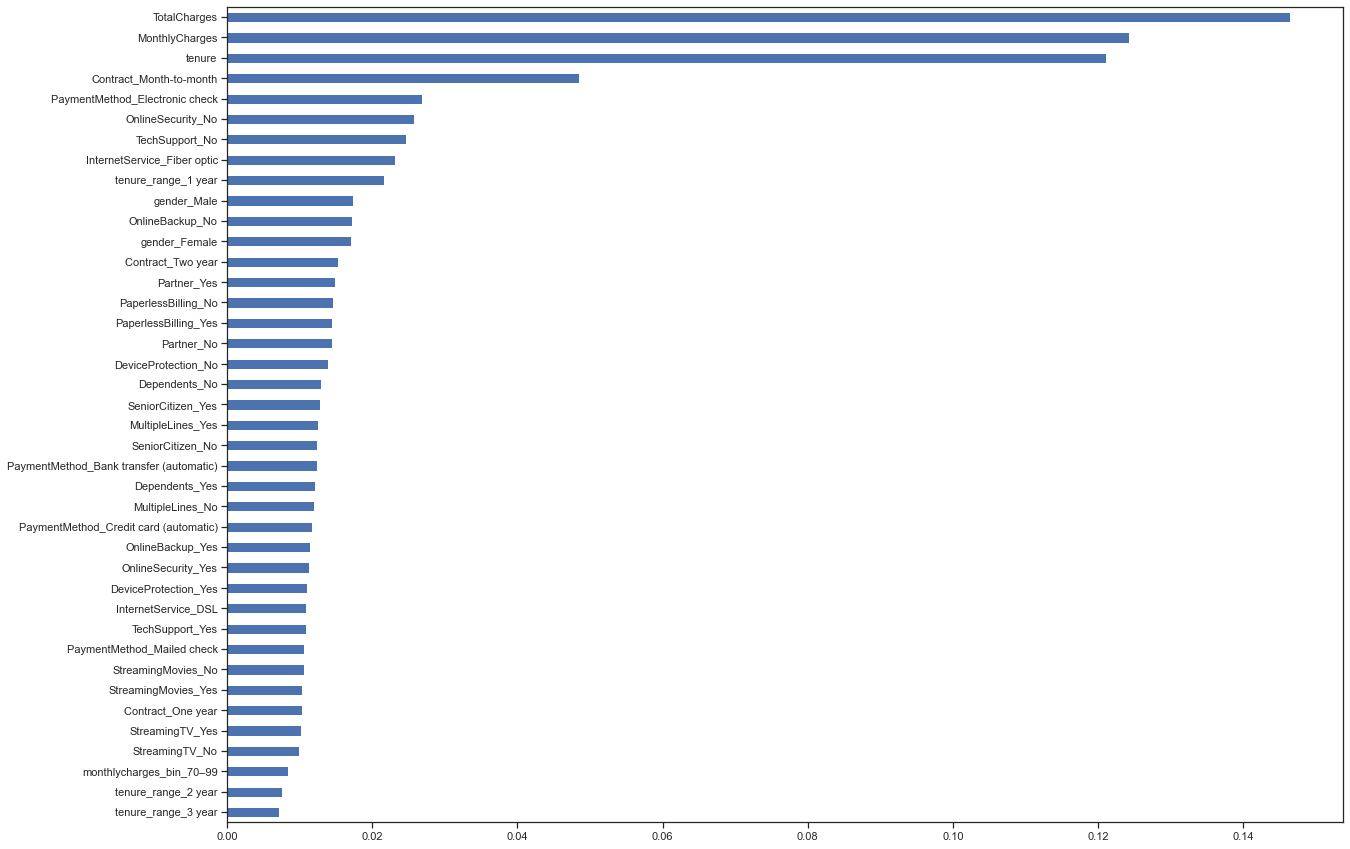

In [18]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, n_estimators=100)
model = rfc.fit(X, y)
(pd.Series(model.feature_importances_, index=X.columns)
   .nlargest(40)  
   .plot(kind='barh', figsize=[20,15])
    .invert_yaxis())

# Model Selection

In [19]:
# Cross val metric
def cross_val_metrics(model) :
    scores = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
    for sc in scores:
        scores = cross_val_score(model, X, y, cv = 5, scoring = sc)
        print('[%s] : %0.5f (+/- %0.5f)'%(sc, scores.mean(), scores.std()))

In [20]:
%%time
lgbm_clf = lgbm.LGBMClassifier(n_estimators=1500, random_state = 42)

lgbm_clf.fit(X_train, y_train)
lgbm_clf.fit(X_train, y_train)
y_pred = lgbm_clf.predict(X_test)
y_score = lgbm_clf.predict_proba(X_test)[:,1]

cross_val_metrics(lgbm_clf)

[accuracy] : 0.77197 (+/- 0.00869)
[precision] : 0.58478 (+/- 0.02171)
[recall] : 0.48796 (+/- 0.01000)
[f1] : 0.53189 (+/- 0.01343)
[roc_auc] : 0.80571 (+/- 0.00963)
Wall time: 2min 2s


In [21]:
# AdaBoost Algorithm
from sklearn.ensemble import AdaBoostClassifier

adb_clf = AdaBoostClassifier()
adb_clf.fit(X_train,y_train)
y_pred = adb_clf.predict(X_test)
y_score = adb_clf.predict_proba(X_test)[:,1]

cross_val_metrics(adb_clf)


[accuracy] : 0.80463 (+/- 0.00687)
[precision] : 0.66235 (+/- 0.01784)
[recall] : 0.53879 (+/- 0.01617)
[f1] : 0.59406 (+/- 0.01402)
[roc_auc] : 0.84563 (+/- 0.01221)


In [22]:
from sklearn.linear_model import LogisticRegression

lgr_clf = LogisticRegression()
lgr_clf.fit(X_train, y_train)
y_pred = lgr_clf.predict(X_test)
y_score = lgr_clf.predict_proba(X_test)[:,1]

cross_val_metrics(lgr_clf)


[accuracy] : 0.80477 (+/- 0.00756)
[precision] : 0.66667 (+/- 0.01777)
[recall] : 0.52863 (+/- 0.01635)
[f1] : 0.58964 (+/- 0.01656)
[roc_auc] : 0.84710 (+/- 0.01124)


In [23]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=1000 , oob_score = True, n_jobs = -1,
                                  random_state =50, max_features = "auto",
                                  max_leaf_nodes = 30)
rf_clf.fit(X_train, y_train)

# Make predictions
y_pred = rf_clf.predict(X_test)
y_score = rf_clf.predict_proba(X_test)[:,1]

cross_val_metrics(rf_clf)

[accuracy] : 0.79895 (+/- 0.01131)
[precision] : 0.67353 (+/- 0.03345)
[recall] : 0.47191 (+/- 0.01669)
[f1] : 0.55485 (+/- 0.02164)
[roc_auc] : 0.84552 (+/- 0.01084)


In [24]:
from xgboost import XGBClassifier
from sklearn import metrics
xgb_clf= XGBClassifier()
xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
y_score = xgb_clf.predict_proba(X_test)[:,1]

metrics.accuracy_score(y_test, y_pred)


0.7770941788925698

In [25]:
cross_val_metrics(model)

[accuracy] : 0.78561 (+/- 0.01508)
[precision] : 0.62570 (+/- 0.03904)
[recall] : 0.48154 (+/- 0.02254)
[f1] : 0.54401 (+/- 0.02751)
[roc_auc] : 0.81916 (+/- 0.01330)
